In [1]:
# Standard library imports
import argparse
import copy
import gc
import logging
import math
import os
import random
import shutil
import warnings
from contextlib import nullcontext
from pathlib import Path

# Third-party library imports
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from PIL import Image
from PIL.ImageOps import exif_transpose

# Hugging Face libraries
import transformers
from transformers import (
    CLIPTextModel,
    CLIPTokenizer,
    AutoTokenizer,
    PretrainedConfig,
)
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
import datasets
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from huggingface_hub.utils import insecure_hashlib
from packaging import version

# Diffusers library imports
import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)
from diffusers.loaders import LoraLoaderMixin
from diffusers.optimization import get_scheduler
from diffusers.training_utils import (
    _set_state_dict_into_text_encoder,
    cast_training_params,
    compute_snr,
)
from diffusers.utils import (
    check_min_version,
    convert_state_dict_to_diffusers,
    convert_unet_state_dict_to_peft,
    is_wandb_available,
)
from diffusers.utils.hub_utils import load_or_create_model_card, populate_model_card
from diffusers.utils.import_utils import is_xformers_available
from diffusers.utils.torch_utils import is_compiled_module

# PEFT (Parameter Efficient Fine Tuning) imports
from peft import LoraConfig
from peft.utils import get_peft_model_state_dict, set_peft_model_state_dict

# Custom utility imports
from utils import *

gc.collect()
torch.cuda.empty_cache()

# Device configuration
device = "cuda"
print(torch.cuda.memory_summary())


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [2]:
def seed_everything(seed=2024):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def image_grid(imgs, rows, cols):
    """
    Concatenates multiple images
    """
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

# LoRA Training

In [3]:
if is_wandb_available():
    import wandb

logger = get_logger(__name__, log_level="INFO")


def log_validation(
    pipeline,
    args,
    accelerator,
    epoch,
    is_final_validation=False,
    save_dir=None,
):
    logger.info(
        f"Running validation... \n Generating {args.num_validation_images} images with prompt:"
        f" {args.validation_prompt}."
    )
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)
    generator = torch.Generator(device=accelerator.device)
    if args.seed is not None:
        generator = generator.manual_seed(args.seed)
    images = []

    if torch.backends.mps.is_available():
        autocast_ctx = nullcontext()
    else:
        autocast_ctx = torch.autocast(accelerator.device.type)

    image_logs = []

    with autocast_ctx:
        for _ in range(args.num_validation_images):
            image = pipeline(
                args.validation_prompt, 
                num_inference_steps=30, 
                generator=generator
            ).images[0]
            images.append(image)
        
        image_logs.append(
            {
                "images": images, 
                "validation_prompt": args.validation_prompt
            }
        )
    
    # Save the concatenated validation output
    if save_dir is not None:
        image_list = []
        for image_log in image_logs:
            images = image_log["images"]
            image_concat = image_grid(images, 1, len(images))
            image_list.append(image_concat)
        
        image_val_full = image_grid(image_list, len(image_list), 1)
        image_val_full.save(
            os.path.join(save_dir, f"epoch_{epoch:06d}.png")
        )

    for tracker in accelerator.trackers:
        phase_name = "test" if is_final_validation else "validation"
        
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images(phase_name, np_images, epoch, dataformats="NHWC")
        
        if tracker.name == "wandb":
            tracker.log(
                {
                    phase_name: [
                        wandb.Image(image, caption=f"{i}: {args.validation_prompt}") for i, image in enumerate(images)
                    ]
                }
            )
    return images


def parse_args(input_args=None):
    parser = argparse.ArgumentParser(description="Simple example of a training script.")
    parser.add_argument(
        "--pretrained_model_name_or_path",
        type=str,
        default=None,
        required=True,
        help="Path to pretrained model or model identifier from huggingface.co/models.",
    )
    parser.add_argument(
        "--revision",
        type=str,
        default=None,
        required=False,
        help="Revision of pretrained model identifier from huggingface.co/models.",
    )
    parser.add_argument(
        "--variant",
        type=str,
        default=None,
        help="Variant of the model files of the pretrained model identifier from huggingface.co/models, 'e.g.' fp16",
    )
    parser.add_argument(
        "--dataset_name",
        type=str,
        default=None,
        help=(
            "The name of the Dataset (from the HuggingFace hub) to train on (could be your own, possibly private,"
            " dataset). It can also be a path pointing to a local copy of a dataset in your filesystem,"
            " or to a folder containing files that 🤗 Datasets can understand."
        ),
    )
    parser.add_argument(
        "--dataset_config_name",
        type=str,
        default=None,
        help="The config of the Dataset, leave as None if there's only one config.",
    )
    parser.add_argument(
        "--train_data_dir",
        type=str,
        default=None,
        help=(
            "A folder containing the training data. Folder contents must follow the structure described in"
            " https://huggingface.co/docs/datasets/image_dataset#imagefolder. In particular, a `metadata.jsonl` file"
            " must exist to provide the captions for the images. Ignored if `dataset_name` is specified."
        ),
    )
    parser.add_argument(
        "--image_column", type=str, default="image", help="The column of the dataset containing an image."
    )
    parser.add_argument(
        "--caption_column",
        type=str,
        default="text",
        help="The column of the dataset containing a caption or a list of captions.",
    )
    parser.add_argument(
        "--validation_prompt", type=str, default=None, help="A prompt that is sampled during training for inference."
    )
    parser.add_argument(
        "--num_validation_images",
        type=int,
        default=4,
        help="Number of images that should be generated during validation with `validation_prompt`.",
    )
    parser.add_argument(
        "--validation_epochs",
        type=int,
        default=1,
        help=(
            "Run fine-tuning validation every X epochs. The validation process consists of running the prompt"
            " `args.validation_prompt` multiple times: `args.num_validation_images`."
        ),
    )
    parser.add_argument(
        "--max_train_samples",
        type=int,
        default=None,
        help=(
            "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        ),
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default="sd-model-finetuned-lora",
        help="The output directory where the model predictions and checkpoints will be written.",
    )
    parser.add_argument(
        "--cache_dir",
        type=str,
        default=None,
        help="The directory where the downloaded models and datasets will be stored.",
    )
    parser.add_argument("--seed", type=int, default=None, help="A seed for reproducible training.")
    parser.add_argument(
        "--resolution",
        type=int,
        default=512,
        help=(
            "The resolution for input images, all the images in the train/validation dataset will be resized to this"
            " resolution"
        ),
    )
    parser.add_argument(
        "--center_crop",
        default=False,
        action="store_true",
        help=(
            "Whether to center crop the input images to the resolution. If not set, the images will be randomly"
            " cropped. The images will be resized to the resolution first before cropping."
        ),
    )
    parser.add_argument(
        "--random_flip",
        action="store_true",
        help="whether to randomly flip images horizontally",
    )
    parser.add_argument(
        "--train_batch_size", type=int, default=16, help="Batch size (per device) for the training dataloader."
    )
    parser.add_argument("--num_train_epochs", type=int, default=100)
    parser.add_argument(
        "--max_train_steps",
        type=int,
        default=None,
        help="Total number of training steps to perform.  If provided, overrides num_train_epochs.",
    )
    parser.add_argument(
        "--gradient_accumulation_steps",
        type=int,
        default=1,
        help="Number of updates steps to accumulate before performing a backward/update pass.",
    )
    parser.add_argument(
        "--gradient_checkpointing",
        action="store_true",
        help="Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.",
    )
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=1e-4,
        help="Initial learning rate (after the potential warmup period) to use.",
    )
    parser.add_argument(
        "--scale_lr",
        action="store_true",
        default=False,
        help="Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.",
    )
    parser.add_argument(
        "--lr_scheduler",
        type=str,
        default="constant",
        help=(
            'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
            ' "constant", "constant_with_warmup"]'
        ),
    )
    parser.add_argument(
        "--lr_warmup_steps", type=int, default=500, help="Number of steps for the warmup in the lr scheduler."
    )
    parser.add_argument(
        "--snr_gamma",
        type=float,
        default=None,
        help="SNR weighting gamma to be used if rebalancing the loss. Recommended value is 5.0. "
        "More details here: https://arxiv.org/abs/2303.09556.",
    )
    parser.add_argument(
        "--use_8bit_adam", action="store_true", help="Whether or not to use 8-bit Adam from bitsandbytes."
    )
    parser.add_argument(
        "--allow_tf32",
        action="store_true",
        help=(
            "Whether or not to allow TF32 on Ampere GPUs. Can be used to speed up training. For more information, see"
            " https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices"
        ),
    )
    parser.add_argument(
        "--dataloader_num_workers",
        type=int,
        default=0,
        help=(
            "Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."
        ),
    )
    parser.add_argument("--adam_beta1", type=float, default=0.9, help="The beta1 parameter for the Adam optimizer.")
    parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
    parser.add_argument("--adam_weight_decay", type=float, default=1e-2, help="Weight decay to use.")
    parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer")
    parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
    parser.add_argument("--hub_token", type=str, default=None, help="The token to use to push to the Model Hub.")
    parser.add_argument(
        "--prediction_type",
        type=str,
        default=None,
        help="The prediction_type that shall be used for training. Choose between 'epsilon' or 'v_prediction' or leave `None`. If left to `None` the default prediction type of the scheduler: `noise_scheduler.config.prediction_type` is chosen.",
    )
    parser.add_argument(
        "--hub_model_id",
        type=str,
        default=None,
        help="The name of the repository to keep in sync with the local `output_dir`.",
    )
    parser.add_argument(
        "--logging_dir",
        type=str,
        default="logs",
        help=(
            "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
            " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
        ),
    )
    parser.add_argument(
        "--mixed_precision",
        type=str,
        default=None,
        choices=["no", "fp16", "bf16"],
        help=(
            "Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
            " 1.10.and an Nvidia Ampere GPU.  Default to the value of accelerate config of the current system or the"
            " flag passed with the `accelerate.launch` command. Use this argument to override the accelerate config."
        ),
    )
    parser.add_argument(
        "--report_to",
        type=str,
        default="tensorboard",
        help=(
            'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
            ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
        ),
    )
    parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
    parser.add_argument(
        "--checkpointing_steps",
        type=int,
        default=500,
        help=(
            "Save a checkpoint of the training state every X updates. These checkpoints are only suitable for resuming"
            " training using `--resume_from_checkpoint`."
        ),
    )
    parser.add_argument(
        "--checkpoints_total_limit",
        type=int,
        default=None,
        help=("Max number of checkpoints to store."),
    )
    parser.add_argument(
        "--resume_from_checkpoint",
        type=str,
        default=None,
        help=(
            "Whether training should be resumed from a previous checkpoint. Use a path saved by"
            ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.'
        ),
    )
    parser.add_argument(
        "--enable_xformers_memory_efficient_attention", action="store_true", help="Whether or not to use xformers."
    )
    parser.add_argument("--noise_offset", type=float, default=0, help="The scale of noise offset.")
    parser.add_argument(
        "--rank",
        type=int,
        default=4,
        help=("The dimension of the LoRA update matrices."),
    )

    if input_args is not None:
        args = parser.parse_args(input_args)
    else:
        args = parser.parse_args()
        
    env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
    if env_local_rank != -1 and env_local_rank != args.local_rank:
        args.local_rank = env_local_rank

    # Sanity checks
    if args.dataset_name is None and args.train_data_dir is None:
        raise ValueError("Need either a dataset name or a training folder.")

    return args


DATASET_NAME_MAPPING = {
    "lambdalabs/naruto-blip-captions": ("image", "text"),
}


def main(args):
    args = parse_args()
    if args.report_to == "wandb" and args.hub_token is not None:
        raise ValueError(
            "You cannot use both --report_to=wandb and --hub_token due to a security risk of exposing your token."
            " Please use `huggingface-cli login` to authenticate with the Hub."
        )

    logging_dir = Path(args.output_dir, args.logging_dir)

    accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
        log_with=args.report_to,
        project_config=accelerator_project_config,
    )

    # Disable AMP for MPS.
    if torch.backends.mps.is_available():
        accelerator.native_amp = False

    # Make one log on every process with the configuration for debugging.
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )
    logger.info(accelerator.state, main_process_only=False)
    if accelerator.is_local_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_warning()
        diffusers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()
        diffusers.utils.logging.set_verbosity_error()

    # If passed along, set the training seed now.
    if args.seed is not None:
        set_seed(args.seed)

    # Handle the repository creation
    if accelerator.is_main_process:
        if args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)
            os.makedirs(os.path.join(args.output_dir, "validation"), exist_ok=True)

    # Load scheduler, tokenizer and models.
    noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
    tokenizer = CLIPTokenizer.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="tokenizer", revision=args.revision
    )
    text_encoder = CLIPTextModel.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
    )
    vae = AutoencoderKL.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="vae", revision=args.revision, variant=args.variant
    )
    unet = UNet2DConditionModel.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision, variant=args.variant
    )
    # freeze parameters of models to save more memory
    unet.requires_grad_(False)
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)

    # For mixed precision training we cast all non-trainable weights (vae, non-lora text_encoder and non-lora unet) to half-precision
    # as these weights are only used for inference, keeping weights in full precision is not required.
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Freeze the unet parameters before adding adapters
    for param in unet.parameters():
        param.requires_grad_(False)

    unet_lora_config = LoraConfig(
        r=args.rank,
        lora_alpha=args.rank,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )

    # Move unet, vae and text_encoder to device and cast to weight_dtype
    unet.to(accelerator.device, dtype=weight_dtype)
    vae.to(accelerator.device, dtype=weight_dtype)
    text_encoder.to(accelerator.device, dtype=weight_dtype)

    # Add adapter and make sure the trainable params are in float32.
    unet.add_adapter(unet_lora_config)
    if args.mixed_precision == "fp16":
        # only upcast trainable parameters (LoRA) into fp32
        cast_training_params(unet, dtype=torch.float32)

    if args.enable_xformers_memory_efficient_attention:
        if is_xformers_available():
            import xformers

            xformers_version = version.parse(xformers.__version__)
            if xformers_version == version.parse("0.0.16"):
                logger.warning(
                    "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
                )
            unet.enable_xformers_memory_efficient_attention()
        else:
            raise ValueError("xformers is not available. Make sure it is installed correctly")

    lora_layers = filter(lambda p: p.requires_grad, unet.parameters())

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Enable TF32 for faster training on Ampere GPUs,
    # cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
    if args.allow_tf32:
        torch.backends.cuda.matmul.allow_tf32 = True

    if args.scale_lr:
        args.learning_rate = (
            args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    if args.use_8bit_adam:
        try:
            import bitsandbytes as bnb
        except ImportError:
            raise ImportError(
                "Please install bitsandbytes to use 8-bit Adam. You can do so by running `pip install bitsandbytes`"
            )

        optimizer_cls = bnb.optim.AdamW8bit
    else:
        optimizer_cls = torch.optim.AdamW

    optimizer = optimizer_cls(
        lora_layers,
        lr=args.learning_rate,
        betas=(args.adam_beta1, args.adam_beta2),
        weight_decay=args.adam_weight_decay,
        eps=args.adam_epsilon,
    )

    # Get the datasets: you can either provide your own training and evaluation files (see below)
    # or specify a Dataset from the hub (the dataset will be downloaded automatically from the datasets Hub).

    # In distributed training, the load_dataset function guarantees that only one local process can concurrently
    # download the dataset.
    if args.dataset_name is not None:
        # Downloading and loading a dataset from the hub.
        dataset = load_dataset(
            args.dataset_name,
            args.dataset_config_name,
            cache_dir=args.cache_dir,
            data_dir=args.train_data_dir,
        )
    else:
        data_files = {}
        if args.train_data_dir is not None:
            data_files["train"] = os.path.join(args.train_data_dir, "**")
            
        dataset = load_dataset(
            "imagefolder",
            data_files=data_files,
            cache_dir=args.cache_dir,
        )
        # See more about loading custom images at
        # https://huggingface.co/docs/datasets/v2.4.0/en/image_load#imagefolder

    # Preprocessing the datasets.
    # We need to tokenize inputs and targets.
    column_names = dataset["train"].column_names

    # 6. Get the column names for input/target.
    dataset_columns = DATASET_NAME_MAPPING.get(args.dataset_name, None)
    if args.image_column is None:
        image_column = dataset_columns[0] if dataset_columns is not None else column_names[0]
    else:
        image_column = args.image_column
        if image_column not in column_names:
            raise ValueError(
                f"--image_column' value '{args.image_column}' needs to be one of: {', '.join(column_names)}"
            )
    if args.caption_column is None:
        caption_column = dataset_columns[1] if dataset_columns is not None else column_names[1]
    else:
        caption_column = args.caption_column
        if caption_column not in column_names:
            raise ValueError(
                f"--caption_column' value '{args.caption_column}' needs to be one of: {', '.join(column_names)}"
            )

    # Preprocessing the datasets.
    # We need to tokenize input captions and transform the images.
    def tokenize_captions(examples, is_train=True):
        captions = []
        for caption in examples[caption_column]:
            if isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        inputs = tokenizer(
            captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        return inputs.input_ids

    # Preprocessing the datasets.
    train_transforms = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
            transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    def unwrap_model(model):
        model = accelerator.unwrap_model(model)
        model = model._orig_mod if is_compiled_module(model) else model
        return model

    def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]
        examples["pixel_values"] = [train_transforms(image) for image in images]
        examples["input_ids"] = tokenize_captions(examples)
        return examples

    with accelerator.main_process_first():
        if args.max_train_samples is not None:
            dataset["train"] = dataset["train"].shuffle(seed=args.seed).select(range(args.max_train_samples))
        # Set the training transforms
        train_dataset = dataset["train"].with_transform(preprocess_train)

    def collate_fn(examples):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
        input_ids = torch.stack([example["input_ids"] for example in examples])
        return {"pixel_values": pixel_values, "input_ids": input_ids}

    # DataLoaders creation:
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=True,
        collate_fn=collate_fn,
        batch_size=args.train_batch_size,
        num_workers=args.dataloader_num_workers,
    )

    # Scheduler and math around the number of training steps.
    # Check the PR https://github.com/huggingface/diffusers/pull/8312 for detailed explanation.
    num_warmup_steps_for_scheduler = args.lr_warmup_steps * accelerator.num_processes
    if args.max_train_steps is None:
        len_train_dataloader_after_sharding = math.ceil(len(train_dataloader) / accelerator.num_processes)
        num_update_steps_per_epoch = math.ceil(len_train_dataloader_after_sharding / args.gradient_accumulation_steps)
        num_training_steps_for_scheduler = (
            args.num_train_epochs * num_update_steps_per_epoch * accelerator.num_processes
        )
    else:
        num_training_steps_for_scheduler = args.max_train_steps * accelerator.num_processes

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps_for_scheduler,
        num_training_steps=num_training_steps_for_scheduler,
    )

    # Prepare everything with our `accelerator`.
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    if args.max_train_steps is None:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
        if num_training_steps_for_scheduler != args.max_train_steps * accelerator.num_processes:
            logger.warning(
                f"The length of the 'train_dataloader' after 'accelerator.prepare' ({len(train_dataloader)}) does not match "
                f"the expected length ({len_train_dataloader_after_sharding}) when the learning rate scheduler was created. "
                f"This inconsistency may result in the learning rate scheduler not functioning properly."
            )
    # Afterwards we recalculate our number of training epochs
    args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    if accelerator.is_main_process:
        accelerator.init_trackers("text2image-fine-tune", config=vars(args))

    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Num Epochs = {args.num_train_epochs}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    global_step = 0
    first_epoch = 0

    # Potentially load in the weights and states from a previous save
    if args.resume_from_checkpoint:
        if args.resume_from_checkpoint != "latest":
            path = os.path.basename(args.resume_from_checkpoint)
        else:
            # Get the most recent checkpoint
            dirs = os.listdir(args.output_dir)
            dirs = [d for d in dirs if d.startswith("checkpoint")]
            dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
            path = dirs[-1] if len(dirs) > 0 else None

        if path is None:
            accelerator.print(
                f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
            )
            args.resume_from_checkpoint = None
            initial_global_step = 0
        else:
            accelerator.print(f"Resuming from checkpoint {path}")
            accelerator.load_state(os.path.join(args.output_dir, path))
            global_step = int(path.split("-")[1])

            initial_global_step = global_step
            first_epoch = global_step // num_update_steps_per_epoch
    else:
        initial_global_step = 0

    progress_bar = tqdm(
        range(0, args.max_train_steps),
        initial=initial_global_step,
        desc="Steps",
        # Only show the progress bar once on each machine.
        disable=not accelerator.is_local_main_process,
    )

    for epoch in range(first_epoch, args.num_train_epochs):
        unet.train()
        train_loss = 0.0
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                if args.noise_offset:
                    # https://www.crosslabs.org//blog/diffusion-with-offset-noise
                    noise += args.noise_offset * torch.randn(
                        (latents.shape[0], latents.shape[1], 1, 1), device=latents.device
                    )

                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"], return_dict=False)[0]

                # Get the target for loss depending on the prediction type
                if args.prediction_type is not None:
                    # set prediction_type of scheduler if defined
                    noise_scheduler.register_to_config(prediction_type=args.prediction_type)

                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                # Predict the noise residual and compute loss
                model_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]

                if args.snr_gamma is None:
                    loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
                else:
                    # Compute loss-weights as per Section 3.4 of https://arxiv.org/abs/2303.09556.
                    # Since we predict the noise instead of x_0, the original formulation is slightly changed.
                    # This is discussed in Section 4.2 of the same paper.
                    snr = compute_snr(noise_scheduler, timesteps)
                    mse_loss_weights = torch.stack([snr, args.snr_gamma * torch.ones_like(timesteps)], dim=1).min(
                        dim=1
                    )[0]
                    if noise_scheduler.config.prediction_type == "epsilon":
                        mse_loss_weights = mse_loss_weights / snr
                    elif noise_scheduler.config.prediction_type == "v_prediction":
                        mse_loss_weights = mse_loss_weights / (snr + 1)

                    loss = F.mse_loss(model_pred.float(), target.float(), reduction="none")
                    loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                    loss = loss.mean()

                # Gather the losses across all processes for logging (if we use distributed training).
                avg_loss = accelerator.gather(loss.repeat(args.train_batch_size)).mean()
                train_loss += avg_loss.item() / args.gradient_accumulation_steps

                # Backpropagate
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    params_to_clip = lora_layers
                    accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                accelerator.log({"train_loss": train_loss}, step=global_step)
                train_loss = 0.0

                if global_step % args.checkpointing_steps == 0:
                    if accelerator.is_main_process:
                        # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                        if args.checkpoints_total_limit is not None:
                            checkpoints = os.listdir(args.output_dir)
                            checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                            checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                            # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                            if len(checkpoints) >= args.checkpoints_total_limit:
                                num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                                removing_checkpoints = checkpoints[0:num_to_remove]

                                logger.info(
                                    f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                                )
                                logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                                for removing_checkpoint in removing_checkpoints:
                                    removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                    shutil.rmtree(removing_checkpoint)

                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        accelerator.save_state(save_path)

                        unwrapped_unet = unwrap_model(unet)
                        unet_lora_state_dict = convert_state_dict_to_diffusers(
                            get_peft_model_state_dict(unwrapped_unet)
                        )

                        StableDiffusionPipeline.save_lora_weights(
                            save_directory=save_path,
                            unet_lora_layers=unet_lora_state_dict,
                            safe_serialization=True,
                        )

                        logger.info(f"Saved state to {save_path}")

            logs = {"step_loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        if accelerator.is_main_process:
            if (
                args.validation_prompt is not None and 
                epoch % args.validation_epochs == 0
            ):
                # create pipeline
                pipeline = DiffusionPipeline.from_pretrained(
                    args.pretrained_model_name_or_path,
                    unet=unwrap_model(unet),
                    revision=args.revision,
                    variant=args.variant,
                    torch_dtype=weight_dtype,
                )
                images = log_validation(
                    pipeline, 
                    args, 
                    accelerator, 
                    epoch,
                    save_dir=os.path.join(args.output_dir, "validation")
                )

                del pipeline
                torch.cuda.empty_cache()

    # Save the lora layers
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        unet = unet.to(torch.float32)

        unwrapped_unet = unwrap_model(unet)
        unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unwrapped_unet))
        
        StableDiffusionPipeline.save_lora_weights(
            save_directory=args.output_dir,
            unet_lora_layers=unet_lora_state_dict,
            safe_serialization=True,
        )

        # Final inference
        # Load previous pipeline
        if args.validation_prompt is not None:
            pipeline = DiffusionPipeline.from_pretrained(
                args.pretrained_model_name_or_path,
                revision=args.revision,
                variant=args.variant,
                torch_dtype=weight_dtype,
            )

            # load attention processors
            pipeline.load_lora_weights(args.output_dir)

            # run inference
            images = log_validation(
                pipeline, 
                args, 
                accelerator, 
                epoch, 
                is_final_validation=True,
                save_dir=os.path.join(args.output_dir, "validation")
            )

    accelerator.end_training()
    
sim_args = [
    "--pretrained_model_name_or_path", "CompVis/stable-diffusion-v1-4",
    "--output_dir", "./runs/sd-naruto-model-lora",
    "--dataset_name", "lambdalabs/naruto-blip-captions",
    "--caption_column", "text",
    "--resolution", "128",
    "--random_flip",
    "--train_batch_size", "4",
    "--num_train_epochs", "10",
    "--validation_epochs", "1",
    "--checkpointing_steps", "1000",
    "--learning_rate", "1e-4",
    "--lr_scheduler", "constant",
    "--lr_warmup_steps", "0",
    "--use_8bit_adam",
    "--seed", "42",
    "--checkpoints_total_limit", "2",
    "--validation_prompt", "a cute bear",
    "--mixed_precision", "fp16",
    "--gradient_accumulation_steps", "2",
    "--gradient_checkpointing",
    "--enable_xformers_memory_efficient_attention",
]

import sys
if __name__ == "__main__":
    sys.argv = [sys.argv[0]] + sim_args
    argv = parse_args()
    main(argv)

/home/x_elmoghm/.local/lib/python3.10/site-packages/accelerate/accelerator.py:453: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
01/19/2025 09:33:12 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'thresholding', 'prediction_type', 'variance_type', 'timestep_spacing', 'rescale_betas_zero_snr', 'sample_max_value', 'dynamic_thresholding_ratio', 'clip_sample_range'} was not found in config. Values will be initialized to default values.
{'mid_block_add_attention', 'norm_num_groups', 'force_upcast', 'shift_factor', 'use_quant_conv', 'use_post_quant_conv', 'latents_mean', 'latents_std'} was not found in config. Values will be initialized to default values.
{'conv_in_kernel', 'cross_attention_norm', 'timestep_post_act', 'encoder_hid_dim', 'a

Repo card metadata block was not found. Setting CardData to empty.
01/19/2025 09:33:16 - WARNING - huggingface_hub.repocard - Repo card metadata block was not found. Setting CardData to empty.
01/19/2025 09:33:20 - INFO - __main__ - ***** Running training *****
01/19/2025 09:33:20 - INFO - __main__ -   Num examples = 1221
01/19/2025 09:33:20 - INFO - __main__ -   Num Epochs = 10
01/19/2025 09:33:20 - INFO - __main__ -   Instantaneous batch size per device = 4
01/19/2025 09:33:20 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 8
01/19/2025 09:33:20 - INFO - __main__ -   Gradient Accumulation steps = 2
01/19/2025 09:33:20 - INFO - __main__ -   Total optimization steps = 1530


Steps:   0%|          | 0/1530 [00:00<?, ?it/s]

{'requires_safety_checker', 'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'mid_block_add_attention', 'norm_num_groups', 'force_upcast', 'shift_factor', 'use_quant_conv', 'use_post_quant_conv', 'latents_mean', 'latents_std'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of CompVis/stable-diffusion-v1-4.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of CompVis/stable-diffusion-v1-4.
{'timestep_spacing', 'prediction_type'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of CompVis/stable-diffusion-v1-4.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of CompVis/stable-diffusion-v1-4.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of CompVis/stable-diffusion-v1-4.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of CompVis/stable-diffusion-v1-4.
01/19/2025 09:35:31 - INFO - __main__ - Running validatio

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'mid_block_add_attention', 'norm_num_groups', 'force_upcast', 'shift_factor', 'use_quant_conv', 'use_post_quant_conv', 'latents_mean', 'latents_std'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of CompVis/stable-diffusion-v1-4.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of CompVis/stable-diffusion-v1-4.
{'timestep_spacing', 'prediction_type'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of CompVis/stable-diffusion-v1-4.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of CompVis/stable-diffusion-v1-4.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of CompVis/stable-diffusion-v1-4.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of CompVis/stable-diffusion-v1-4.
01/19/2025 09:37:51 - INFO - __main__ - Running validatio

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'mid_block_add_attention', 'norm_num_groups', 'force_upcast', 'shift_factor', 'use_quant_conv', 'use_post_quant_conv', 'latents_mean', 'latents_std'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of CompVis/stable-diffusion-v1-4.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of CompVis/stable-diffusion-v1-4.
{'timestep_spacing', 'prediction_type'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of CompVis/stable-diffusion-v1-4.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of CompVis/stable-diffusion-v1-4.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of CompVis/stable-diffusion-v1-4.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of CompVis/stable-diffusion-v1-4.
01/19/2025 09:40:10 - INFO - __main__ - Running validatio

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'mid_block_add_attention', 'norm_num_groups', 'force_upcast', 'shift_factor', 'use_quant_conv', 'use_post_quant_conv', 'latents_mean', 'latents_std'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of CompVis/stable-diffusion-v1-4.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of CompVis/stable-diffusion-v1-4.
{'timestep_spacing', 'prediction_type'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of CompVis/stable-diffusion-v1-4.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of CompVis/stable-diffusion-v1-4.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of CompVis/stable-diffusion-v1-4.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of CompVis/stable-diffusion-v1-4.
01/19/2025 09:42:24 - INFO - __main__ - Running validatio

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'mid_block_add_attention', 'norm_num_groups', 'force_upcast', 'shift_factor', 'use_quant_conv', 'use_post_quant_conv', 'latents_mean', 'latents_std'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of CompVis/stable-diffusion-v1-4.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of CompVis/stable-diffusion-v1-4.
{'timestep_spacing', 'prediction_type'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of CompVis/stable-diffusion-v1-4.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of CompVis/stable-diffusion-v1-4.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of CompVis/stable-diffusion-v1-4.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of CompVis/stable-diffusion-v1-4.
01/19/2025 09:44:44 - INFO - __main__ - Running validatio

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'mid_block_add_attention', 'norm_num_groups', 'force_upcast', 'shift_factor', 'use_quant_conv', 'use_post_quant_conv', 'latents_mean', 'latents_std'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of CompVis/stable-diffusion-v1-4.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of CompVis/stable-diffusion-v1-4.
{'timestep_spacing', 'prediction_type'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of CompVis/stable-diffusion-v1-4.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of CompVis/stable-diffusion-v1-4.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of CompVis/stable-diffusion-v1-4.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of CompVis/stable-diffusion-v1-4.
01/19/2025 09:47:04 - INFO - __main__ - Running validatio

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'mid_block_add_attention', 'norm_num_groups', 'force_upcast', 'shift_factor', 'use_quant_conv', 'use_post_quant_conv', 'latents_mean', 'latents_std'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of CompVis/stable-diffusion-v1-4.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of CompVis/stable-diffusion-v1-4.
{'timestep_spacing', 'prediction_type'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of CompVis/stable-diffusion-v1-4.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of CompVis/stable-diffusion-v1-4.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of CompVis/stable-diffusion-v1-4.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of CompVis/stable-diffusion-v1-4.
01/19/2025 09:49:27 - INFO - __main__ - Running validatio

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'mid_block_add_attention', 'norm_num_groups', 'force_upcast', 'shift_factor', 'use_quant_conv', 'use_post_quant_conv', 'latents_mean', 'latents_std'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of CompVis/stable-diffusion-v1-4.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of CompVis/stable-diffusion-v1-4.
{'timestep_spacing', 'prediction_type'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of CompVis/stable-diffusion-v1-4.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of CompVis/stable-diffusion-v1-4.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of CompVis/stable-diffusion-v1-4.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of CompVis/stable-diffusion-v1-4.
01/19/2025 09:51:47 - INFO - __main__ - Running validatio

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'mid_block_add_attention', 'norm_num_groups', 'force_upcast', 'shift_factor', 'use_quant_conv', 'use_post_quant_conv', 'latents_mean', 'latents_std'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of CompVis/stable-diffusion-v1-4.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of CompVis/stable-diffusion-v1-4.
{'timestep_spacing', 'prediction_type'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of CompVis/stable-diffusion-v1-4.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of CompVis/stable-diffusion-v1-4.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of CompVis/stable-diffusion-v1-4.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of CompVis/stable-diffusion-v1-4.
01/19/2025 09:54:04 - INFO - __main__ - Running validatio

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'mid_block_add_attention', 'norm_num_groups', 'force_upcast', 'shift_factor', 'use_quant_conv', 'use_post_quant_conv', 'latents_mean', 'latents_std'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of CompVis/stable-diffusion-v1-4.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of CompVis/stable-diffusion-v1-4.
{'timestep_spacing', 'prediction_type'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of CompVis/stable-diffusion-v1-4.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of CompVis/stable-diffusion-v1-4.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of CompVis/stable-diffusion-v1-4.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of CompVis/stable-diffusion-v1-4.
01/19/2025 09:56:13 - INFO - __main__ - Running validatio

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'conv_in_kernel', 'cross_attention_norm', 'timestep_post_act', 'encoder_hid_dim', 'attention_type', 'resnet_out_scale_factor', 'conv_out_kernel', 'num_class_embeds', 'only_cross_attention', 'addition_embed_type', 'time_cond_proj_dim', 'reverse_transformer_layers_per_block', 'addition_time_embed_dim', 'mid_block_only_cross_attention', 'time_embedding_act_fn', 'class_embeddings_concat', 'time_embedding_dim', 'projection_class_embeddings_input_dim', 'resnet_time_scale_shift', 'upcast_attention', 'class_embed_type', 'num_attention_heads', 'addition_embed_type_num_heads', 'mid_block_type', 'use_linear_projection', 'resnet_skip_time_act', 'time_embedding_type', 'dropout', 'encoder_hid_dim_type', 'dual_cross_attention', 'transformer_layers_per_block'} was not found in config. Values will be initialized to default values.
Loaded unet as UNet2DConditionModel from `unet` subfolder of CompVis/stable-diffusion-v1-4.
{'mid_block_add_attention', 'norm_num_groups', 'force_upcast', 'shift_factor', 'u

In [45]:
seed = torch.randint(0, 1000, (1,)).item()
seed

87

# Inference

{'requires_safety_checker', 'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

{'conv_in_kernel', 'cross_attention_norm', 'timestep_post_act', 'encoder_hid_dim', 'attention_type', 'resnet_out_scale_factor', 'conv_out_kernel', 'num_class_embeds', 'only_cross_attention', 'addition_embed_type', 'time_cond_proj_dim', 'reverse_transformer_layers_per_block', 'addition_time_embed_dim', 'mid_block_only_cross_attention', 'time_embedding_act_fn', 'class_embeddings_concat', 'time_embedding_dim', 'projection_class_embeddings_input_dim', 'resnet_time_scale_shift', 'upcast_attention', 'class_embed_type', 'num_attention_heads', 'addition_embed_type_num_heads', 'mid_block_type', 'use_linear_projection', 'resnet_skip_time_act', 'time_embedding_type', 'dropout', 'encoder_hid_dim_type', 'dual_cross_attention', 'transformer_layers_per_block'} was not found in config. Values will be initialized to default values.
Loaded unet as UNet2DConditionModel from `unet` subfolder of CompVis/stable-diffusion-v1-4.
{'mid_block_add_attention', 'norm_num_groups', 'force_upcast', 'shift_factor', 'u

[INFO] Successfully loaded Stable Diffusion!
854, SD prompt=A man with sunglasses


  0%|          | 0/100 [00:00<?, ?it/s]

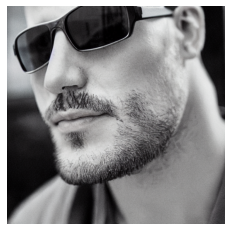

91, SD prompt=A man smiling


  0%|          | 0/100 [00:00<?, ?it/s]

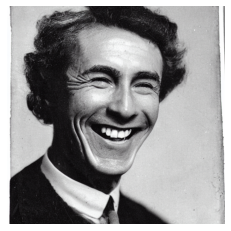

17, SD prompt=a man with a hoodie and sunglasses


  0%|          | 0/100 [00:00<?, ?it/s]

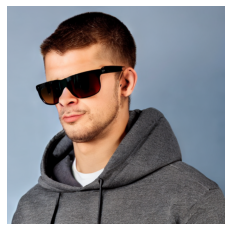

137, SD prompt=An old woman with blue hair and green eyes


  0%|          | 0/100 [00:00<?, ?it/s]

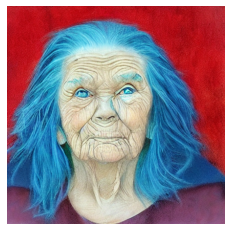

Loading unet.


[INFO] Successfully loaded LoRA weights!
104, LoRA prompt=A man with sunglasses


  0%|          | 0/100 [00:00<?, ?it/s]

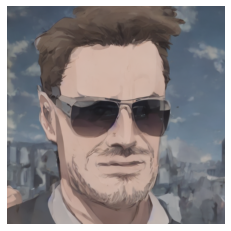

684, LoRA prompt=A man smiling


  0%|          | 0/100 [00:00<?, ?it/s]

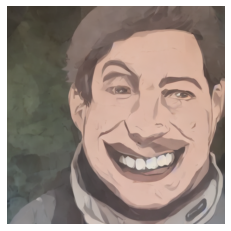

180, LoRA prompt=a man with a hoodie and sunglasses


  0%|          | 0/100 [00:00<?, ?it/s]

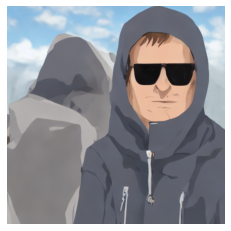

390, LoRA prompt=An old woman with blue hair and green eyes


  0%|          | 0/100 [00:00<?, ?it/s]

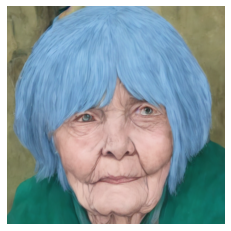

In [66]:
import json
import matplotlib.pyplot as plt
from diffusers.utils import load_image
import numpy as np

# Prompts path
file_path = os.path.join("LoRA-Data/LoRA-naruto-blip","test_prompts.json")
with open(file_path,'r') as f:
    dict_inference = json.load(f)

# Load SD Model
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    torch_dtype=torch.float16,
    safety_checker=None
).to(device)
print("[INFO] Successfully loaded Stable Diffusion!")

# SD Output Before Training
for key, prompt in dict_inference.items():
    
    # Random Seed
    seed = torch.randint(0, 1000, (1,)).item()
    generator = torch.Generator(device)
    generator.manual_seed(seed)
    print(f"{seed}, SD prompt={prompt}")
    
    image = pipe(
    prompt, 
    num_inference_steps=100, 
    guidance_scale=7.5,
    generator=generator
    ).images[0]
    
    plt.imshow(image)
    plt.axis('off') 
    plt.show()  
    
    image.save(f"./LoRA-Data/LoRA-naruto-blip/sdxl/SD-{key}.png")
    
# Load LoRA Weights
lora_path = "./runs/sd-naruto-model-lora"
# lora_path = "./runs/artistic_custom"
# lora_path = "./runs/dreambooth_cat"
# lora_path = "./runs/dreambooth_dog_bella"
# lora_path = "./runs/pokemon_custom/checkpoint-2000"
# lora_path = None  # if not using LoRA

if lora_path is not None:
    pipe.load_lora_weights(lora_path)
    print("[INFO] Successfully loaded LoRA weights!")
    
pipe = pipe.to(device)

# SD Output after LoRA Training
for key, prompt in dict_inference.items():
    
    # Random Seed
    seed = torch.randint(0, 1000, (1,)).item()
    seed = 104 if key == "0" else seed
    seed = 684 if key == "1" else seed #636
    seed = 180 if key == "2" else seed
    seed = 390 if key == "3" else seed
    generator = torch.Generator(device)
    generator.manual_seed(seed)
    print(f"{seed}, LoRA prompt={prompt}")
    
    image = pipe(
    prompt, 
    num_inference_steps=100, 
    guidance_scale=7.5,
    generator=generator
    ).images[0]
    
    plt.imshow(image)
    plt.axis('off') 
    plt.show()
    
    image.save(f"./LoRA-Data/LoRA-naruto-blip/output/LoRA-{key}.png")



# prompt = "a bear wearing sunglasses"
# prompt = "a man with sunglasses"
# prompt = ["A photo of sks dog in a bucket"]*4 + ["A photo of sks dog running on the grass"]*4
# prompt = ['A pokeman man'] * 4 + ['A Horsea dog'] * 4


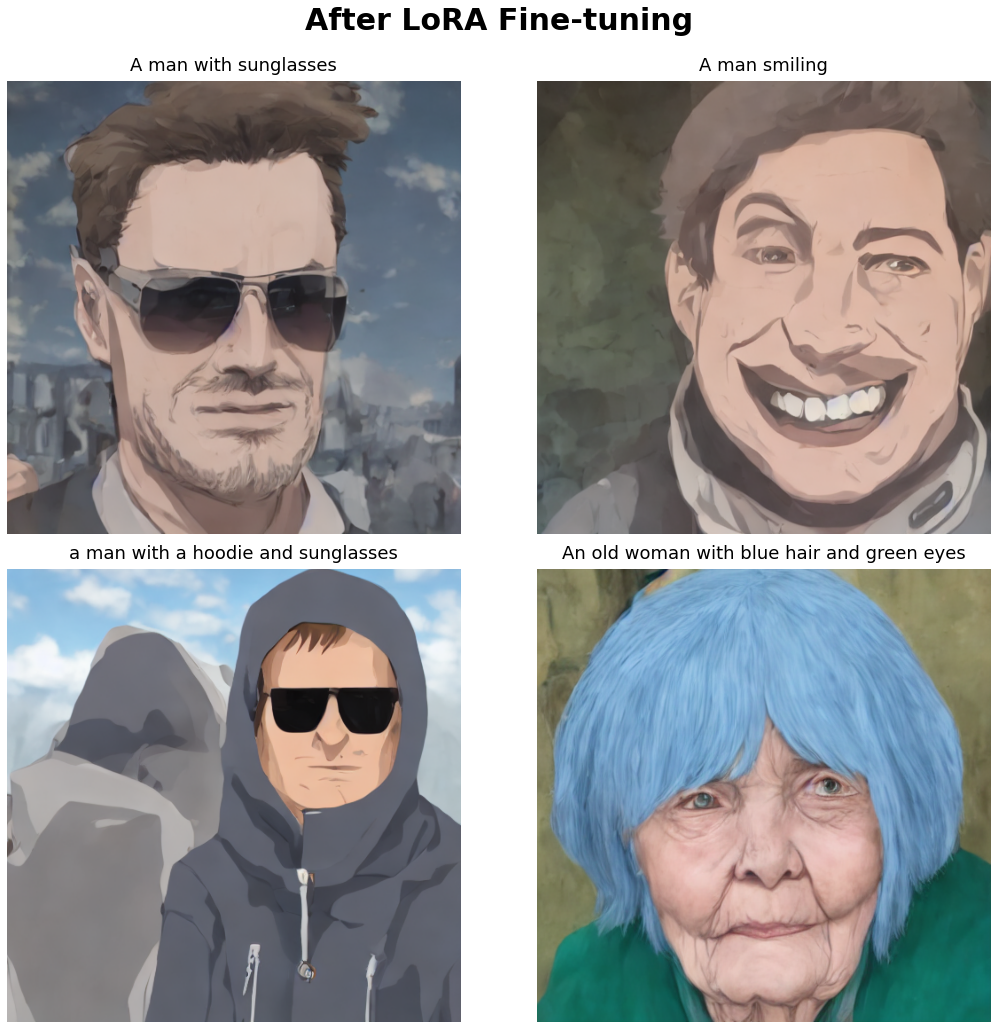

In [ ]:
# Directory containing images and prompts file
results_dir = "LoRA-Data/LoRA-naruto-blip"
images_dir = "LoRA-Data/LoRA-naruto-blip/output"
prompts_file = os.path.join(results_dir, "test_prompts.json")

# Load prompts from the JSON file
with open(prompts_file, 'r') as f:
    dict_inference = json.load(f)

# Get all image file paths
image_files = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Sort image files for consistency with prompt keys
image_files.sort()

# Check if there are images to display
if not image_files:
    print("No images found in the directory.")
else:
    # Display images
    plt.figure(figsize=(15, 15))  # Set figure size for larger images
    plt.suptitle("After LoRA Fine-tuning", fontsize=30, weight='bold', y=0.95)  # Add main title

    for i, img_path in enumerate(image_files):
        img = Image.open(img_path)
        plt.subplot(len(image_files) // 2 + len(image_files) % 2, 2, i + 1)
        plt.imshow(img)
        plt.axis('off')
        # Add a prompt for each image
        prompt = dict_inference.get(str(i), "No prompt available")
        plt.title(prompt, fontsize=18, y=1.01)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    output_path = os.path.join(results_dir, "After-LoRA.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Image grid saved to {results_dir}")

    plt.show()
